In [131]:
import keras
import numpy as np
import tensorflow as tf
from tqdm.auto import tqdm, trange


# Prepare data

In [133]:
import unicodedata
import regex as re

def normalize_text(text):
    clean_text=text.lower()
    clean_text=re.sub(r"[^a-zA-Z0-9\säåö]"," ",clean_text)
    #clean_text=re.sub(r"[^\S\n]+"," ",clean_text)
    clean_text=re.sub(r"\s+"," ",clean_text)
    clean_text=re.sub(r"^\s","",clean_text)
    clean_text=re.sub(r"\s$","",clean_text)
    return clean_text

normalize_text("äåöjkjh jhjk j1hkj"),normalize_text("jFjh.jhjk,.,.ef jhkj "),normalize_text(" jkjh jhjk jhkj")

('äåöjkjh jhjk j1hkj', 'jfjh jhjk ef jhkj', 'jkjh jhjk jhkj')

In [ ]:
import csv
finnish_company_names=[]
with open('fullprhdata.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    for row in csv_reader:
        finnish_company_names.append(row[0])
json.dump(finnish_company_names,open("finnish_registry_companies.json","w+"))

In [136]:
import csv
it_company_names=[]
with open('companies_sorted.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in tqdm(csv_reader):
        if "information" in row[4]:
            it_company_names.append(row[1])
json.dump(it_company_names,open("it_company_names.json","w+"))


In [142]:
import json 
import random

dictionary_language=[]

# add finnish words
with open("./kaikkisanat.list.txt","r+") as f:
    dictionary_language.extend(f.read().split("\n"))


In [144]:
import json 
import random

dictionary_companies=[]

# add finnish companies
dictionary_companies.extend(json.load(open("it_company_names.json","r+")))

# add finnish companies
dictionary_companies.extend(json.load(open("finnish_registry_companies.json","r+")))


In [157]:

def prepare_dictionary(dictionary, max_size):
    # preprocess dictionary  
    dataset=[normalize_text(word) for word in dictionary if len(word)<max_size]
    dataset = [word for word in dataset if "asunto" not in word]

    random.shuffle(dataset)
    all_text="".join(trimmed)

    characters=sorted(list(set(all_text)))
    characters=[".","E"]+characters # . is none, E is end of line
    char_indices = dict((c, i) for i, c in enumerate(characters))
    indices_char = dict((i, c) for i, c in enumerate(characters))

    print("\n".join(random.choices(dataset,k=5)))
    print()
    print(f"Found names:", len(dataset))
    print("Characters:","".join(characters))
    print("Chars: ",len(characters))
    print("Max Size (Tx): ",max_size)
    return dataset
    
prepare_dictionary(dictionary_companies, 15)[-100:]

kuvapaja oy
erpekon oy
ab transla oy
epromptus inc
diskcopy oy

Found names: 302847
Characters: .E 0123456789abcdefghijklmnopqrstuvwxyzäåö
Chars:  42
Max Size (Tx):  15


['ottima srl',
 'naijabidzone',
 'trafi',
 'arktraining oy',
 'hubswirl inc',
 'jettadel oy',
 'srhives',
 'system 4t',
 'mai art oy',
 'rp proservices',
 'agiletrick',
 'interstation',
 'new math oy',
 're metal oy',
 'smart360',
 'sapia',
 'lintulahti oy',
 'bnb infotech',
 'eristystrio oy',
 'foxys',
 'shirai cz',
 'auditron gmbh',
 'koskipaja oy',
 'mcm partners',
 'acklabs io',
 'savola oy',
 'a j salmela oy',
 'it support',
 'tokyo steak',
 'onnentassu oy',
 'optovita oy',
 'thinkvine',
 'pneumacon oy',
 'solver oy',
 'del valle',
 'ezek digital',
 'h2c consult',
 'foretra oy',
 'snatch oy',
 'finnlimo oy',
 'yourrequest bv',
 'electsys',
 'compeon oy',
 'kidwell',
 'matroid games',
 'virate oy',
 'domotika sia',
 'leadeo groupe',
 'tilanomi oy',
 'cocon oy',
 'kit consulting',
 'boxtasis',
 'hark',
 'jj logistik oy',
 'contelec',
 'the fastlink',
 'kannustalo oy',
 'prospear it',
 'mgveras',
 'rarus agency',
 'gigness llc',
 'bobiten ab',
 'amcham bolivia',
 'proteo uk',
 'plane

In [154]:
def str_to_vec(word, start_with_null=False):
    """
    Converts word to vec
    
    word -- string
    
    returns array of shape (Tx, len(chars))
    """
    if start_with_null:
        word="."+word
    x = np.zeros((len(word), len(characters)), dtype=np.bool)
    for t, char in enumerate(word):
        x[t, char_indices[char]] = 1
    return x
    
def vec_to_str(vec, debug=False):
    """
    Converts vec to word
    
    vec -- array of shape (Tx, len(chars))
    
    """
    word=""
    for i in range(vec.shape[0]):
        word+=indices_char[np.argmax(vec[i])]
    
    if debug==False:
        word=word.replace("E","").replace(".","")
    return word

a=str_to_vec("hello world",start_with_null=True)
print(vec_to_str(a))

hello world


In [171]:
def vectorization(words, n_x, Tx=None):
    """
    Convert X and Y (lists) into arrays to be given to a recurrent neural network.
    
    Arguments:
    X -- 
    Y -- 
    Tx -- integer, sequence length
    
    Returns:
    x -- array of shape (m, Tx, len(chars))
    y -- array of shape (m, Tx, len(chars))
    """
    random.seed(42)
    random.shuffle(words)
    if Tx is None:
        Tx=len(max(words,key=len))
        print(Tx)
    
    m = len(words)
    x = np.zeros((m, Tx, n_x), dtype=np.bool)
    y = np.zeros((m, Tx, n_x), dtype=np.bool)
    
    for w, word in enumerate(tqdm(words)):
        word=word[:Tx]
        x[w, 0:len(word)+1, :] = str_to_vec(word,start_with_null=True)
        x[w, len(word)+1:, char_indices["E"]] = 1
        
        y[w, 0:len(word),:] = str_to_vec(word)
        y[w, len(word):, char_indices["E"]] = 1
        
    return x, y 

Tx=15
X,Y=vectorization(prepare_dictionary(dictionary_companies, Tx), n_x=len(characters), Tx=Tx)
X.shape, Y.shape 

3kits
ecfirst
infra 10 oy
manatee works
sevifield oy

Found names: 302847
Characters: .E 0123456789abcdefghijklmnopqrstuvwxyzäåö
Chars:  42
Max Size (Tx):  15


((302847, 15, 42), (302847, 15, 42))

In [173]:
id_=3430
for id_ in random.choices(range(X.shape[0]),k=5):
    print(vec_to_str(X[id_],debug=True))
    print(vec_to_str(np.array(Y[id_])))
    print()

.tks yhtiö oyEE
tks yhtiö oy

.edg incEEEEEEE
edg inc

.inx incEEEEEEE
inx inc

.bdit groupEEEE
bdit group

.destia oyEEEEE
destia oy



In [162]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    out = np.random.choice(range(len(characters)), p = probas.ravel())
    out=characters[out]
    return out

def generate_output(model, text_start, length=5):
    
    for diversity in np.arange(0.1,2,0.2):
        print(f"Diversity: {diversity}")
        for l in range(length):
            generated = '\n'
            sentence = ('{0:\n>' + str(Tx) + '}').format(text_start).lower()
            generated += text_start 
            gens=0

            generated = ""
            inp=text_start
            sentence = inp

            x_pred = np.zeros((1, Tx, len(characters)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            for pred in preds:
                next_index = sample(pred)
                next_char = next_index
                sentence = sentence + next_char
                generated += next_char
            print(f"{inp}{generated}")
        
generate_output(model,"")

Diversity: 0.1
mvtiatkaplkuoEE
skrleyk EoöEEEE
slmmtvisoyu iEE
cesurnsjolsEEyE
fijlai aEEEEtoE
Diversity: 0.30000000000000004
sakallEovuEtEEE
pamhdbbekoE EEE
sebiomoEplt  EE
hipkaptöm EEöEE
beiscnEijoolEEE
Diversity: 0.5000000000000001
kiitcmnlEyyEEEE
poniilsrtE EiEE
kcittnyoaEyEEEE
sorkitiuvuEoEEE
suajn tEleE EEE
Diversity: 0.7000000000000001
sspiuht  EoEEEE
kirsma soEEoEEE
tekea m oEnitEE
taotlalityicyEE
hekirsiasEdEoEE
Diversity: 0.9000000000000001
kstanikouEEtjEE
rykaeeekoaEoEEE
hiheinyk koEEEE
fäl lknlyEeaEEE
pw blhsEkEEEEEE
Diversity: 1.1000000000000003
yi usinxaEEEyEE
rintla kaaEEEEE
koäkditbir EEEE
remn ieEE oaaEE
tyuuotEavEEEäEE
Diversity: 1.3000000000000003
tey aanbEasEoEE
surnenneEEEEEEE
bnmvrjshmeioEEE
kaleskmEiayyEEE
tanaaelojEEyyEE
Diversity: 1.5000000000000004
releieooip EEEE
aeheimrEoydEEEE
jetiiiujkoEaEEE
sl eyöEEeExEyEE
dpatioioeEEyEEE
Diversity: 1.7000000000000004
oiuktknseE yEEE
luaitoeEnfEEEEE
dodaeknämayyEEE
mpnheujiaEEEpEE
fhnttarElEytEEE
Diversity: 1.90000000000

# Model

In [48]:
def make_name(model, beginning=""):
    name = beginning
    x = np.zeros((1, Tx, len(characters)))
    x[0,0:len(beginning),:]=str_to_vec(beginning,start_with_null=False)

    for i in range(len(beginning),Tx-1):
        prediction=model.predict(x)[0]
        probs = list(prediction[i])
        probs = probs / np.sum(probs)
        index = np.random.choice(range(len(characters)), p=probs)
        #index = np.argmax(prediction[i])
        character = indices_char[index]
        #print(f"{vec_to_str(x[0])} -> {vec_to_str(prediction)} -> {character}")
        if character=="E":
            break
        name+=character
        x[0, i+1, index] = 1

        i += 1
    
    print(name)
for i in range(100):
    make_name(model,".teko")

.tekotadande oy
.tekosain lotge oy
.tekosolerkuma oy
.tekosiinden colk oy
.tekoxgat oy
.tekoda teit oy
.tekoseola oy
.tekodoline oy
.tekohaer taiis oy
.tekotorem oy
.tekoce haujetuk oy
.tekogine esmavawa oy
.tekoko oy
.tekos kitkon oy
.teko2 troan oy
.tekogass oy
.tekosautisjoy
.tekosaan tilactolarechy
.tekosamosmom oy
.tekogimeg semetalt oy
.tekosinicpor oy
.tekosinsaitiing lrong o
.tekoelini oy
.tekodolngine oy
.tekosinnö oy
.tekosin ji nhran mäujet
.tekosujilulupuonto oy
.tekosinmox oy
.tekosoza rerainti maane
.tekogre oy
.tekosuvons oy
.tekokoaspuin kelvar flo
.tekosren oy
.tekosuto oy
.tekocl talu oy
.tekosanviomen ab osin o
.tekopunerykot oy
.tekosere oy
.tekosovibo oy
.tekoginseps oy
.tekosp oy
.tekogimeos oy
.tekosekun sen oy
.tekost oy oy
.tekooomice oy
.tekosintol menkumensuvo
.tekoarentarutne oy
.tekoslicon oy
.tekogirinner oy
.tekoko oy
.tekog hictamamkint pemo
.tekosinraan ska 328 oy
.tekosimaacpuns
.tekogiukapun aöy
.tekoges afoicolu oy
.teko8en fanviket oy
.tekog fannsh 

In [28]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

drp=0
model=models.Sequential()
model.add(LSTM(8, input_shape=(Tx, len(characters)), return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25, 8)             1632      
_________________________________________________________________
dense_1 (Dense)              (None, 25, 42)            378       
Total params: 2,010
Trainable params: 2,010
Non-trainable params: 0
_________________________________________________________________


In [12]:
from keras.callbacks import LambdaCallback

def on_epoch_end(epoch, logs):
    print()
    for i in range(3):
        make_name(model,"")
        
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


In [29]:
#opt=keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer="adam")

history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=1000, shuffle=True, callbacks=[print_callback],verbose=1)

Epoch 1/1000
6309/6317 [============================>.] - ETA: 0s - loss: 1.6472
cescese oy
jyiseiipit oy
5
6317/6317 [==============================] - 43s 7ms/step - loss: 1.6471 - val_loss: 1.4638
Epoch 2/1000
6313/6317 [============================>.] - ETA: 0s - loss: 1.4320
rsdo ginga uhatd oy
ivalbukvettung oy
y8bäh cteri bauptervion 
6317/6317 [==============================] - 40s 6ms/step - loss: 1.4321 - val_loss: 1.4192
Epoch 3/1000
6313/6317 [============================>.] - ETA: 0s - loss: 1.4027
kulrir oy
huosuvenpounte oy
åmisuin oy
6317/6317 [==============================] - 41s 6ms/step - loss: 1.4028 - val_loss: 1.3993
Epoch 4/1000
6309/6317 [============================>.] - ETA: 0s - loss: 1.3875
rkäime oy
er gisgu ab
supose oy
6317/6317 [==============================] - 41s 6ms/step - loss: 1.3874 - val_loss: 1.3873
Epoch 5/1000
6313/6317 [============================>.] - ETA: 0s - loss: 1.3780
hran muusaentee oy
reuto oy
as koiva oy
6317/6317 [===============

Epoch 39/1000
6316/6317 [============================>.] - ETA: 0s - loss: 1.3443
26 kitent oy
1244 srosoin sepahtei oy
eluc oy
6317/6317 [==============================] - 36s 6ms/step - loss: 1.3443 - val_loss: 1.3488
Epoch 40/1000
6311/6317 [============================>.] - ETA: 0s - loss: 1.3440
dab 4 m oy
sy x oy
cpäika oy
6317/6317 [==============================] - 36s 6ms/step - loss: 1.3440 - val_loss: 1.3485
Epoch 41/1000
6313/6317 [============================>.] - ETA: 0s - loss: 1.3438
sen toijoad sketo ab oy
yl holvishuss oy
cmexern arfantri oy
6317/6317 [==============================] - 38s 6ms/step - loss: 1.3438 - val_loss: 1.3484
Epoch 42/1000
6308/6317 [============================>.] - ETA: 0s - loss: 1.3436
rgo asennus oy
sky absaontun oy
zöd oy
6317/6317 [==============================] - 36s 6ms/step - loss: 1.3436 - val_loss: 1.3484
Epoch 43/1000
6317/6317 [==============================] - ETA: 0s - loss: 1.3433
peövata oy
 syickien oy
göt oy
6317/6317 [=====

Epoch 77/1000
6314/6317 [============================>.] - ETA: 0s - loss: 1.3368
dgörerkelns oy
celaten oy
h kaumatlrig oy
6317/6317 [==============================] - 36s 6ms/step - loss: 1.3368 - val_loss: 1.3425
Epoch 78/1000
6309/6317 [============================>.] - ETA: 0s - loss: 1.3366
309g ab
jan oy mehento 2
dgö pima oy
6317/6317 [==============================] - 35s 6ms/step - loss: 1.3366 - val_loss: 1.3418
Epoch 79/1000
6311/6317 [============================>.] - ETA: 0s - loss: 1.3365
kcle lrapuht oy
gösa asardacolh ab
4sy svotise oy
6317/6317 [==============================] - 36s 6ms/step - loss: 1.3365 - val_loss: 1.3418
Epoch 80/1000
6317/6317 [==============================] - ETA: 0s - loss: 1.3363
jeusucio oy
äespvi oy
sonbinvs ttolan invesess
6317/6317 [==============================] - 36s 6ms/step - loss: 1.3363 - val_loss: 1.3416
Epoch 81/1000
6313/6317 [============================>.] - ETA: 0s - loss: 1.3361
dtgo tkkusupiing oy
äegoos pelia saret oy
syva

yd aberi oy
6317/6317 [==============================] - 40s 6ms/step - loss: 1.3319 - val_loss: 1.3377
Epoch 115/1000
6316/6317 [============================>.] - ETA: 0s - loss: 1.3318
äycwrinno peusenti spw o
soikpan oy
s oy ralkib
6317/6317 [==============================] - 42s 7ms/step - loss: 1.3318 - val_loss: 1.3375
Epoch 116/1000
6309/6317 [============================>.] - ETA: 0s - loss: 1.3318
ssy oy
gjuor oy
3g mrentie oy
6317/6317 [==============================] - 40s 6ms/step - loss: 1.3318 - val_loss: 1.3400
Epoch 117/1000
6315/6317 [============================>.] - ETA: 0s - loss: 1.3317
ss oy
gs ekus hyikaitint
suoy malvuhksi oy
6317/6317 [==============================] - 41s 6ms/step - loss: 1.3317 - val_loss: 1.3376
Epoch 118/1000
6309/6317 [============================>.] - ETA: 0s - loss: 1.3316
ssyb oy
espolimäa piud oy
ysuos oy
6317/6317 [==============================] - 40s 6ms/step - loss: 1.3316 - val_loss: 1.3374
Epoch 119/1000
6316/6317 [==============

Epoch 152/1000
6311/6317 [============================>.] - ETA: 0s - loss: 1.3299
2g1s egis fasteli oy
vy finkding ab
sylii ooaab
6317/6317 [==============================] - 36s 6ms/step - loss: 1.3299 - val_loss: 1.3358
Epoch 153/1000
6313/6317 [============================>.] - ETA: 0s - loss: 1.3299
srilegä oy
s finh oy
ssrax oy
6317/6317 [==============================] - 35s 6ms/step - loss: 1.3299 - val_loss: 1.3361
Epoch 154/1000
6314/6317 [============================>.] - ETA: 0s - loss: 1.3298-
spensk oy
syn lelieitiontete oy
saft filro oy
6317/6317 [==============================] - 35s 6ms/step - loss: 1.3298 - val_loss: 1.3354
Epoch 155/1000
6314/6317 [============================>.] - ETA: 0s - loss: 1.3298
sykot oy
syak oy
ysariva oy
6317/6317 [==============================] - 35s 6ms/step - loss: 1.3298 - val_loss: 1.3356
Epoch 156/1000
6310/6317 [============================>.] - ETA: 0s - loss: 1.3297
vysles oy
syrce ettio oy
vyj inranvidens oy
6317/6317 [=========

Epoch 190/1000
6316/6317 [============================>.] - ETA: 0s - loss: 1.3286
gs feionen rest oy
svcka oy
sy oy
6317/6317 [==============================] - 36s 6ms/step - loss: 1.3286 - val_loss: 1.3348
Epoch 191/1000
6313/6317 [============================>.] - ETA: 0s - loss: 1.3286
syb oy
sunsluja oy
cdduoleulrivest oy
6317/6317 [==============================] - 35s 5ms/step - loss: 1.3286 - val_loss: 1.3353
Epoch 192/1000
6316/6317 [============================>.] - ETA: 0s - loss: 1.3286
sossuldo colta oy
sacivel oy
sy girs oy
6317/6317 [==============================] - 35s 6ms/step - loss: 1.3286 - val_loss: 1.3346
Epoch 193/1000
6308/6317 [============================>.] - ETA: 0s - loss: 1.3284
smare oy
3004 praavese oy
sarvesters oy
6317/6317 [==============================] - 36s 6ms/step - loss: 1.3285 - val_loss: 1.3361
Epoch 194/1000
6317/6317 [==============================] - ETA: 0s - loss: 1.3285
sy oy
ssunsuusdo oy
sb
6317/6317 [==============================]

Epoch 228/1000
6312/6317 [============================>.] - ETA: 0s - loss: 1.3277
sraller weuyk oy
sy oy
sllantesu kiinteasi oy
6317/6317 [==============================] - 40s 6ms/step - loss: 1.3277 - val_loss: 1.3337
Epoch 229/1000
6314/6317 [============================>.] - ETA: 0s - loss: 1.3277
sy oy hahyo kiovini
shgan e oy
salja oy
6317/6317 [==============================] - 44s 7ms/step - loss: 1.3277 - val_loss: 1.3339
Epoch 230/1000
6312/6317 [============================>.] - ETA: 0s - loss: 1.3277
sasenta oy
sy xypkirtiiti oy
sy jd oy
6317/6317 [==============================] - 45s 7ms/step - loss: 1.3276 - val_loss: 1.3342
Epoch 231/1000
6311/6317 [============================>.] - ETA: 0s - loss: 1.3276
söodion oy
04g1 u oy
sys meht oy
6317/6317 [==============================] - 45s 7ms/step - loss: 1.3276 - val_loss: 1.3338
Epoch 232/1000
6311/6317 [============================>.] - ETA: 0s - loss: 1.3276
 suuus os oy
 syutinta oulerhto
yäslulu ssvait oy
6317/6317 

Epoch 266/1000
6308/6317 [============================>.] - ETA: 0s - loss: 1.3269
sring oy
suntice oy
salx oy
6317/6317 [==============================] - 35s 5ms/step - loss: 1.3270 - val_loss: 1.3341
Epoch 267/1000
6310/6317 [============================>.] - ETA: 0s - loss: 1.3269
esunniot oy lalutiökur
supeslinen oy
ssaceinde oy
6317/6317 [==============================] - 35s 6ms/step - loss: 1.3269 - val_loss: 1.3357
Epoch 268/1000
6309/6317 [============================>.] - ETA: 0s - loss: 1.3270
syb
sy ldd oy
sundovesi oy
6317/6317 [==============================] - 35s 6ms/step - loss: 1.3269 - val_loss: 1.3336
Epoch 269/1000
6308/6317 [============================>.] - ETA: 0s - loss: 1.3269
suntosu sorkehtutla oy
gy b
sy oy
6317/6317 [==============================] - 36s 6ms/step - loss: 1.3269 - val_loss: 1.3339
Epoch 270/1000
6309/6317 [============================>.] - ETA: 0s - loss: 1.3269
sancari oy
ksb oy
sys oy
6317/6317 [==============================] - 35s 6ms/

Epoch 304/1000
6313/6317 [============================>.] - ETA: 0s - loss: 1.3259
sumhi cointema oy
y3827s oy ab
sutsux llb oy
6317/6317 [==============================] - 47s 7ms/step - loss: 1.3259 - val_loss: 1.3331
Epoch 305/1000
6311/6317 [============================>.] - ETA: 0s - loss: 1.3259
y85135 syb
srginrä oy
y2044s kebituron kenmaiv
6317/6317 [==============================] - 45s 7ms/step - loss: 1.3259 - val_loss: 1.3331
Epoch 306/1000
6314/6317 [============================>.] - ETA: 0s - loss: 1.3259
sy oy
sb
suli oy
6317/6317 [==============================] - 48s 8ms/step - loss: 1.3259 - val_loss: 1.3328
Epoch 307/1000
6312/6317 [============================>.] - ETA: 0s - loss: 1.3259
sukenniss oy
sude oy oy
1465s kiun virting oy
6317/6317 [==============================] - 49s 8ms/step - loss: 1.3259 - val_loss: 1.3331
Epoch 308/1000
6315/6317 [============================>.] - ETA: 0s - loss: 1.3259
spamiar oy
sycco cokenta oy
sbö oy
6317/6317 [================

Epoch 343/1000
6311/6317 [============================>.] - ETA: 0s - loss: 1.3248
4sbur glp oy
sb
sb
6317/6317 [==============================] - 43s 7ms/step - loss: 1.3248 - val_loss: 1.3314
Epoch 344/1000
6310/6317 [============================>.] - ETA: 0s - loss: 1.3248
59893g 1 pulkolumelujko
syb
ssko oy
6317/6317 [==============================] - 42s 7ms/step - loss: 1.3248 - val_loss: 1.3318
Epoch 345/1000
6316/6317 [============================>.] - ETA: 0s - loss: 1.3249
sb
smis oy
sy3309 oy
6317/6317 [==============================] - 43s 7ms/step - loss: 1.3249 - val_loss: 1.3330
Epoch 346/1000
6312/6317 [============================>.] - ETA: 0s - loss: 1.3248
syst oy
gb
svaon oy mttise 38 6
6317/6317 [==============================] - 41s 6ms/step - loss: 1.3248 - val_loss: 1.3326
Epoch 347/1000
6313/6317 [============================>.] - ETA: 0s - loss: 1.3248
src panty pinran4e oy
syb yläninses oy
sangeitius coab oy
6317/6317 [==============================] - 43s 7m

syötins oy
salt h oy
6317/6317 [==============================] - 34s 5ms/step - loss: 1.3238 - val_loss: 1.3314
Epoch 383/1000
6315/6317 [============================>.] - ETA: 0s - loss: 1.3238
sulnok oy
sb
sansondaan sohevö oy
6317/6317 [==============================] - 34s 5ms/step - loss: 1.3238 - val_loss: 1.3304
Epoch 384/1000
6308/6317 [============================>.] - ETA: 0s - loss: 1.3237
sb oy
össuntötuk kiintingi oy
ksaby
6317/6317 [==============================] - 34s 5ms/step - loss: 1.3238 - val_loss: 1.3313
Epoch 385/1000
6314/6317 [============================>.] - ETA: 0s - loss: 1.3238
syhta oy
yäm ts
sb oy
6317/6317 [==============================] - 33s 5ms/step - loss: 1.3238 - val_loss: 1.3330
Epoch 386/1000
6312/6317 [============================>.] - ETA: 0s - loss: 1.3237
gsyvo oy
y915087 erehto menen oy
y7 b
6317/6317 [==============================] - 34s 5ms/step - loss: 1.3237 - val_loss: 1.3305
Epoch 387/1000
6316/6317 [============================>.]

Epoch 462/1000
6311/6317 [============================>.] - ETA: 0s - loss: 1.3219
y0s ab
y0vs
y lappvest hjetpa
6317/6317 [==============================] - 39s 6ms/step - loss: 1.3219 - val_loss: 1.3285
Epoch 463/1000
6317/6317 [==============================] - ETA: 0s - loss: 1.3219
solissiinti oy
sy oy
y10000s aranentuoton oy
6317/6317 [==============================] - 35s 6ms/step - loss: 1.3219 - val_loss: 1.3283
Epoch 464/1000
6317/6317 [==============================] - ETA: 0s - loss: 1.3219
suos oy li oy
sy2
syb
6317/6317 [==============================] - 34s 5ms/step - loss: 1.3219 - val_loss: 1.3284
Epoch 465/1000
6314/6317 [============================>.] - ETA: 0s - loss: 1.3219
y310602s oy holvämt oy
y rikkätden
sb
6317/6317 [==============================] - 34s 5ms/step - loss: 1.3219 - val_loss: 1.3293
Epoch 466/1000
6314/6317 [============================>.] - ETA: 0s - loss: 1.3219
yb
y uoy
yäkänen oy
6317/6317 [==============================] - 34s 5ms/step - lo

Epoch 502/1000
6311/6317 [============================>.] - ETA: 0s - loss: 1.3210
y01700et tolt oy
syb
y
6317/6317 [==============================] - 50s 8ms/step - loss: 1.3211 - val_loss: 1.3288
Epoch 503/1000
6313/6317 [============================>.] - ETA: 0s - loss: 1.3210
sy ab
yhs
syb oy
6317/6317 [==============================] - 46s 7ms/step - loss: 1.3210 - val_loss: 1.3274
Epoch 504/1000
6310/6317 [============================>.] - ETA: 0s - loss: 1.3210
soupuntistö oy
y lless
sunpittaltion lehtinniok
6317/6317 [==============================] - 42s 7ms/step - loss: 1.3210 - val_loss: 1.3309
Epoch 505/1000
6310/6317 [============================>.] - ETA: 0s - loss: 1.3211
gy wemiinsaute oy
syb
skyy
6317/6317 [==============================] - 43s 7ms/step - loss: 1.3211 - val_loss: 1.3274
Epoch 506/1000
6316/6317 [============================>.] - ETA: 0s - loss: 1.3210
sultoinnoon oy
by
sunmana oy
6317/6317 [==============================] - 43s 7ms/step - loss: 1.3210 

6314/6317 [============================>.] - ETA: 0s - loss: 1.3201
s oy
syb
y3 uuy
6317/6317 [==============================] - 34s 5ms/step - loss: 1.3200 - val_loss: 1.3273
Epoch 583/1000
6315/6317 [============================>.] - ETA: 0s - loss: 1.3200
y6 oy2
sy2
ssualtot oy
6317/6317 [==============================] - 34s 5ms/step - loss: 1.3200 - val_loss: 1.3270
Epoch 584/1000
6311/6317 [============================>.] - ETA: 0s - loss: 1.3200
syb
yäsd
yb
6317/6317 [==============================] - 33s 5ms/step - loss: 1.3200 - val_loss: 1.3270
Epoch 585/1000
6308/6317 [============================>.] - ETA: 0s - loss: 1.3201
sys oy
ksy oy
sy oy
6317/6317 [==============================] - 34s 5ms/step - loss: 1.3200 - val_loss: 1.3264
Epoch 586/1000
6309/6317 [============================>.] - ETA: 0s - loss: 1.3200
y122500s haonestio oy
syb
y4
6317/6317 [==============================] - 34s 5ms/step - loss: 1.3200 - val_loss: 1.3270
Epoch 587/1000
6316/6317 [==============

KeyboardInterrupt: 

In [52]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

drp=0
model=models.Sequential()
model.add(LSTM(32, input_shape=(Tx, len(characters)), return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 25, 32)            9600      
_________________________________________________________________
dense_3 (Dense)              (None, 25, 42)            1386      
Total params: 10,986
Trainable params: 10,986
Non-trainable params: 0
_________________________________________________________________


In [53]:
#opt=keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer="adam")

history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=500, shuffle=True, callbacks=[print_callback],verbose=1)

Epoch 1/500
6317/6317 [==============================] - ETA: 0s - loss: 1.4453
114t0.as vionk meltmall 
ientkerperstiö oy
äsännikhott oy
6317/6317 [==============================] - 53s 8ms/step - loss: 1.4453 - val_loss: 1.2980
Epoch 2/500
6315/6317 [============================>.] - ETA: 0s - loss: 1.2534
ura aj oy
purmo oy
09ke oy
6317/6317 [==============================] - 47s 7ms/step - loss: 1.2534 - val_loss: 1.2302
Epoch 3/500
6312/6317 [============================>.] - ETA: 0s - loss: 1.2088
boy visto
vatamo oy
uulto vykinveihto
6317/6317 [==============================] - 49s 8ms/step - loss: 1.2088 - val_loss: 1.2009
Epoch 4/500
6312/6317 [============================>.] - ETA: 0s - loss: 1.1861
4g bour 1
fe hallikenni
almitirus desg lindlas
6317/6317 [==============================] - 56s 9ms/step - loss: 1.1861 - val_loss: 1.1843
Epoch 5/500
6311/6317 [============================>.] - ETA: 0s - loss: 1.1724
utur sähäskönati
rudebogiek
5167 oy nompjanen k 33
6317/6317 [

Epoch 40/500
6317/6317 [==============================] - ETA: 0s - loss: 1.1092
 intöalttic
ntow ab
lorapalo
6317/6317 [==============================] - 47s 7ms/step - loss: 1.1092 - val_loss: 1.1153
Epoch 41/500
6316/6317 [============================>.] - ETA: 0s - loss: 1.1088
 ab
ppogz
terunkkininkuja
6317/6317 [==============================] - 50s 8ms/step - loss: 1.1088 - val_loss: 1.1149
Epoch 42/500
6315/6317 [============================>.] - ETA: 0s - loss: 1.1084
g 8
ron ab
iritent ab
6317/6317 [==============================] - 48s 8ms/step - loss: 1.1084 - val_loss: 1.1147
Epoch 43/500
6311/6317 [============================>.] - ETA: 0s - loss: 1.1081
16 23
polutyka
iv ab
6317/6317 [==============================] - 48s 8ms/step - loss: 1.1081 - val_loss: 1.1141
Epoch 44/500
6312/6317 [============================>.] - ETA: 0s - loss: 1.1078
it ab
 kirkila
 houkkamekkapalm
6317/6317 [==============================] - 48s 8ms/step - loss: 1.1077 - val_loss: 1.1137
Epoch

6315/6317 [============================>.] - ETA: 0s - loss: 1.1007
 itäshas
tela ste iv
 vital ab
6317/6317 [==============================] - 47s 7ms/step - loss: 1.1007 - val_loss: 1.1071
Epoch 82/500
6314/6317 [============================>.] - ETA: 0s - loss: 1.1006
 tria 2
 vietrevi
porgia 13
6317/6317 [==============================] - 47s 7ms/step - loss: 1.1006 - val_loss: 1.1067
Epoch 83/500
6311/6317 [============================>.] - ETA: 0s - loss: 1.1004
fi sinita
op antaprit
belf
6317/6317 [==============================] - 47s 7ms/step - loss: 1.1004 - val_loss: 1.1065
Epoch 84/500
6313/6317 [============================>.] - ETA: 0s - loss: 1.1002
 ab
 jaja
6 mapa ar
6317/6317 [==============================] - 47s 7ms/step - loss: 1.1002 - val_loss: 1.1067
Epoch 85/500
6314/6317 [============================>.] - ETA: 0s - loss: 1.1002
tron ab
 terintie 21
s autohoita
6317/6317 [==============================] - 47s 7ms/step - loss: 1.1002 - val_loss: 1.1067
Epoch 86/

emeting ltd
6317/6317 [==============================] - 48s 8ms/step - loss: 1.0969 - val_loss: 1.1043
Epoch 122/500
6315/6317 [============================>.] - ETA: 0s - loss: 1.0968
bäkkäk48
 liuspelipa
bir nanic
6317/6317 [==============================] - 47s 7ms/step - loss: 1.0968 - val_loss: 1.1042
Epoch 123/500
6310/6317 [============================>.] - ETA: 0s - loss: 1.0967
42 ab
2
t 28
6317/6317 [==============================] - 47s 7ms/step - loss: 1.0968 - val_loss: 1.1030
Epoch 124/500
6313/6317 [============================>.] - ETA: 0s - loss: 1.0966
rotori 4
 kurmarihar
 sihkvisintie
6317/6317 [==============================] - 49s 8ms/step - loss: 1.0967 - val_loss: 1.1035
Epoch 125/500
6313/6317 [============================>.] - ETA: 0s - loss: 1.0966
potkion ltd
fir mestat ltd
s hamponen a
6317/6317 [==============================] - 47s 7ms/step - loss: 1.0966 - val_loss: 1.1035
Epoch 126/500
6317/6317 [==============================] - ETA: 0s - loss: 1.0965

6314/6317 [============================>.] - ETA: 0s - loss: 1.0944
 jolmion nilot
teris jj
villant 16
6317/6317 [==============================] - 44s 7ms/step - loss: 1.0945 - val_loss: 1.1011
Epoch 162/500
6312/6317 [============================>.] - ETA: 0s - loss: 1.0944
st broskrin ltd
 pusatie 1
biti raten ltd
6317/6317 [==============================] - 44s 7ms/step - loss: 1.0944 - val_loss: 1.1015
Epoch 163/500
6314/6317 [============================>.] - ETA: 0s - loss: 1.0944
pori oy
pot rd
 j anilingy
6317/6317 [==============================] - 44s 7ms/step - loss: 1.0944 - val_loss: 1.1016
Epoch 164/500
6311/6317 [============================>.] - ETA: 0s - loss: 1.0943
 yrinols
 finland ltd
poöran linne lth lt
6317/6317 [==============================] - 48s 8ms/step - loss: 1.0943 - val_loss: 1.1017
Epoch 165/500
6311/6317 [============================>.] - ETA: 0s - loss: 1.0942
 kujatopin ab
 ingra ab
 huusenkulla
6317/6317 [==============================] - 51s 8ms/

KeyboardInterrupt: 

In [58]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

drp=0
model=models.Sequential()
model.add(LSTM(64, input_shape=(Tx, len(characters)), return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 25, 64)            27392     
_________________________________________________________________
dense_6 (Dense)              (None, 25, 42)            2730      
Total params: 30,122
Trainable params: 30,122
Non-trainable params: 0
_________________________________________________________________


In [59]:
#opt=keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer="adam")

history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=250, shuffle=True, callbacks=[print_callback],verbose=1)

Epoch 1/250
6313/6317 [============================>.] - ETA: 0s - loss: 1.3703
äkkäe oy
urtojaka ennuss oy
j jyrgroep ab
6317/6317 [==============================] - 61s 10ms/step - loss: 1.3702 - val_loss: 1.2257
Epoch 2/250
6317/6317 [==============================] - ETA: 0s - loss: 1.1772
cusstark oy
kisalutki hion mahora oy
ateen b y mäprinpohom oy
6317/6317 [==============================] - 75s 12ms/step - loss: 1.1772 - val_loss: 1.1545
Epoch 3/250
6317/6317 [==============================] - ETA: 0s - loss: 1.1280
n30 finland oy
idra oy
quus tapsi hyy
6317/6317 [==============================] - 75s 12ms/step - loss: 1.1280 - val_loss: 1.1181
Epoch 4/250
6315/6317 [============================>.] - ETA: 0s - loss: 1.1015
veeranlat oy
imolainen lex oy
ry jet pihlana oy
6317/6317 [==============================] - 85s 13ms/step - loss: 1.1015 - val_loss: 1.0977
Epoch 5/250
6314/6317 [============================>.] - ETA: 0s - loss: 1.0845
jssio nicko oy
 kilipapal oy
bjue fard

6316/6317 [============================>.] - ETA: 0s - loss: 0.9980
k motom oy
licatransheloge ab
hendo ab
6317/6317 [==============================] - 52s 8ms/step - loss: 0.9980 - val_loss: 1.0097
Epoch 79/250
6313/6317 [============================>.] - ETA: 0s - loss: 0.9979
t con invest oy
dealy design oy
ajed oy
6317/6317 [==============================] - 56s 9ms/step - loss: 0.9979 - val_loss: 1.0094
Epoch 80/250
6315/6317 [============================>.] - ETA: 0s - loss: 0.9977
atoroctrice sähkö kärn k
smaly investments oy ab
reesk oy
6317/6317 [==============================] - 59s 9ms/step - loss: 0.9977 - val_loss: 1.0093
Epoch 81/250
6315/6317 [============================>.] - ETA: 0s - loss: 0.9976
ad management ab
f maa oyhimetters ab
vetran ab
6317/6317 [==============================] - 66s 10ms/step - loss: 0.9976 - val_loss: 1.0094
Epoch 82/250
6312/6317 [============================>.] - ETA: 0s - loss: 0.9974
huha finland 1216 oodini
nionikes oy
live oy
6317/6317

Epoch 117/250
6312/6317 [============================>.] - ETA: 0s - loss: 0.9939
jek oy
y solution ab
ane capital oy
6317/6317 [==============================] - 58s 9ms/step - loss: 0.9940 - val_loss: 1.0064
Epoch 118/250
6314/6317 [============================>.] - ETA: 0s - loss: 0.9939
parkki oy
k kasanenkarato oy
amedic oy
6317/6317 [==============================] - 60s 9ms/step - loss: 0.9939 - val_loss: 1.0067
Epoch 119/250
6316/6317 [============================>.] - ETA: 0s - loss: 0.9938
niidus oy
äss consulting ltd
n kotifibstle
6317/6317 [==============================] - 82s 13ms/step - loss: 0.9938 - val_loss: 1.0064
Epoch 120/250
6314/6317 [============================>.] - ETA: 0s - loss: 0.9937
an yhtiöt oy
den ab
 finasling ab
6317/6317 [==============================] - 75s 12ms/step - loss: 0.9937 - val_loss: 1.0072
Epoch 121/250
6314/6317 [============================>.] - ETA: 0s - loss: 0.9937
st tons oy
s log metrukest oy
astolikko oy
6317/6317 [==============

6316/6317 [============================>.] - ETA: 0s - loss: 0.9903
er roster oy
sf oy
allekno oy
6317/6317 [==============================] - 48s 8ms/step - loss: 0.9903 - val_loss: 1.0032
Epoch 196/250
6315/6317 [============================>.] - ETA: 0s - loss: 0.9904
osen martila oy
leus oy
reage oy
6317/6317 [==============================] - 46s 7ms/step - loss: 0.9903 - val_loss: 1.0036
Epoch 197/250
6314/6317 [============================>.] - ETA: 0s - loss: 0.9903
chto ab
latio oy
s storest ab
6317/6317 [==============================] - 46s 7ms/step - loss: 0.9903 - val_loss: 1.0034
Epoch 198/250
6312/6317 [============================>.] - ETA: 0s - loss: 0.9902
ydy i spirtt oy
n group oy
ar oy
6317/6317 [==============================] - 49s 8ms/step - loss: 0.9903 - val_loss: 1.0029
Epoch 199/250
6314/6317 [============================>.] - ETA: 0s - loss: 0.9902
entanatomp oy
endard finland oy
avon services oy
6317/6317 [==============================] - 47s 7ms/step - l

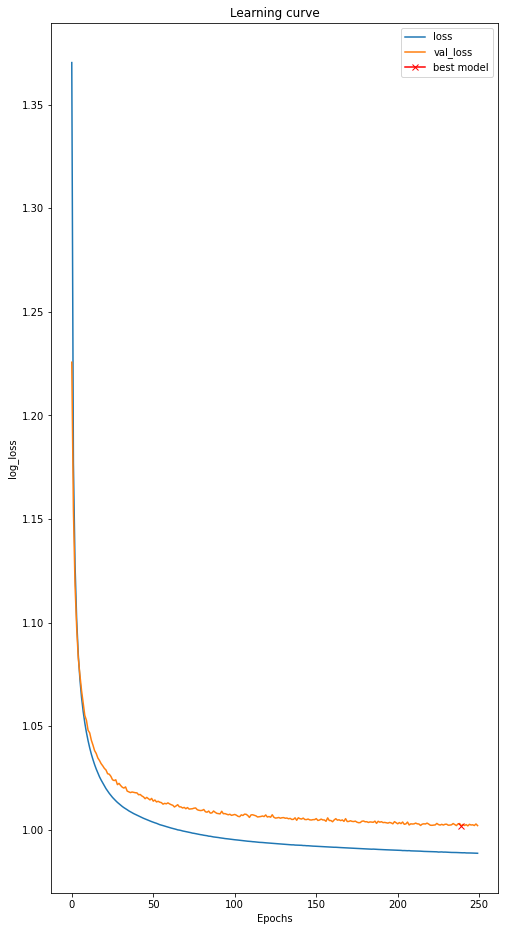

In [60]:
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(8, 16))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


In [61]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

drp=0
model=models.Sequential()
model.add(LSTM(128, input_shape=(Tx, len(characters)), return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 25, 128)           87552     
_________________________________________________________________
dense_7 (Dense)              (None, 25, 42)            5418      
Total params: 92,970
Trainable params: 92,970
Non-trainable params: 0
_________________________________________________________________


In [62]:
#opt=keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer="adam")

history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=250, shuffle=True, callbacks=[print_callback],verbose=1)

Epoch 1/250
6316/6317 [============================>.] - ETA: 0s - loss: 1.3006
slaste oy
wty cbengners ab
1808
6317/6317 [==============================] - 78s 12ms/step - loss: 1.3006 - val_loss: 1.1488
Epoch 2/250
6317/6317 [==============================] - ETA: 0s - loss: 1.0982
ascor oy
chaudidiam designem oy
surunto osuuskanta
6317/6317 [==============================] - 77s 12ms/step - loss: 1.0982 - val_loss: 1.0691
Epoch 3/250
6315/6317 [============================>.] - ETA: 0s - loss: 1.0440
unosteimius oy
mht oy
bzdatt fosset oy
6317/6317 [==============================] - 78s 12ms/step - loss: 1.0440 - val_loss: 1.0343
Epoch 4/250
6314/6317 [============================>.] - ETA: 0s - loss: 1.0162
yntjäkki sport oy
447 teemi oy
orex oy
6317/6317 [==============================] - 86s 14ms/step - loss: 1.0162 - val_loss: 1.0148
Epoch 5/250
6316/6317 [============================>.] - ETA: 0s - loss: 0.9990
494 oy kuuhion konelänsi
trislabiöt oy
 ruusaaur oy
6317/6317 [====

KeyboardInterrupt: 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 25, 96)            53376     
_________________________________________________________________
dense_8 (Dense)              (None, 25, 42)            4074      
Total params: 57,450
Trainable params: 57,450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
6313/6317 [============================>.] - ETA: 0s - loss: 1.3224
fisannesinkk oy
äsäpakkotto oy
nno oy lävirinhave
6317/6317 [==============================] - 76s 12ms/step - loss: 1.3223 - val_loss: 1.1759
Epoch 2/60
6317/6317 [==============================] - ETA: 0s - loss: 1.1279
buodignter ab
geqwosetit oy
 tämi tulatykaasunnus oy
6317/6317 [==============================] - 72s 11ms/step - loss: 1.1279 - val_loss: 1.1011
Epoch 3/60
6313/6317 [============================>.] - ETA: 0s -

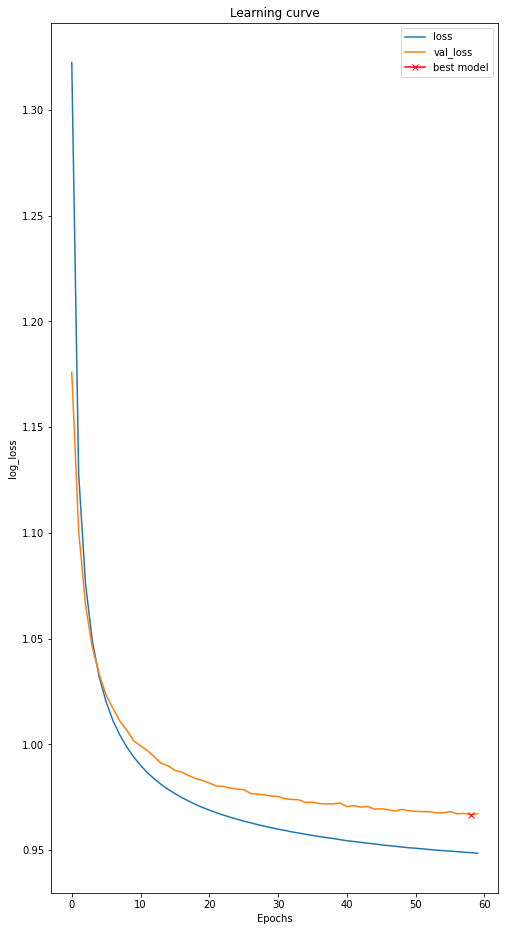

In [63]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

drp=0
model=models.Sequential()
model.add(LSTM(96, input_shape=(Tx, len(characters)), return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

# train
model.compile(loss='categorical_crossentropy', optimizer="adam")
history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=60, shuffle=True, callbacks=[print_callback],verbose=1)

# show
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(8, 16))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 25, 168)           141792    
_________________________________________________________________
dense_9 (Dense)              (None, 25, 42)            7098      
Total params: 148,890
Trainable params: 148,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
6315/6317 [============================>.] - ETA: 0s - loss: 1.2680
uarto senngry oy
7kuuti oy
ångomp stira sp ov
6317/6317 [==============================] - 104s 17ms/step - loss: 1.2680 - val_loss: 1.1168
Epoch 2/60
6316/6317 [============================>.] - ETA: 0s - loss: 1.0653
harkeliikk oy
nibeli oy
mico boiceming tenno oy
6317/6317 [==============================] - 101s 16ms/step - loss: 1.0653 - val_loss: 1.0382
Epoch 3/60
6314/6317 [============================>.] - ETA: 0s - loss

Epoch 38/60
6317/6317 [==============================] - ETA: 0s - loss: 0.8937
ha ankula oy
linkkaasa oy
lutia oy
6317/6317 [==============================] - 113s 18ms/step - loss: 0.8937 - val_loss: 0.9341
Epoch 39/60
6315/6317 [============================>.] - ETA: 0s - loss: 0.8933
 stagee oy
a oy
nnö oy
6317/6317 [==============================] - 111s 18ms/step - loss: 0.8933 - val_loss: 0.9344
Epoch 40/60
6314/6317 [============================>.] - ETA: 0s - loss: 0.8927
stajanpirtti oy
stone oy
bay oy
6317/6317 [==============================] - 117s 19ms/step - loss: 0.8927 - val_loss: 0.9346
Epoch 41/60
6315/6317 [============================>.] - ETA: 0s - loss: 0.8923
jak oy
mp oy
ria oy
6317/6317 [==============================] - 108s 17ms/step - loss: 0.8923 - val_loss: 0.9341
Epoch 42/60
6316/6317 [============================>.] - ETA: 0s - loss: 0.8920
s gara oy
kroora ab
tro oy
6317/6317 [==============================] - 102s 16ms/step - loss: 0.8920 - val_loss: 

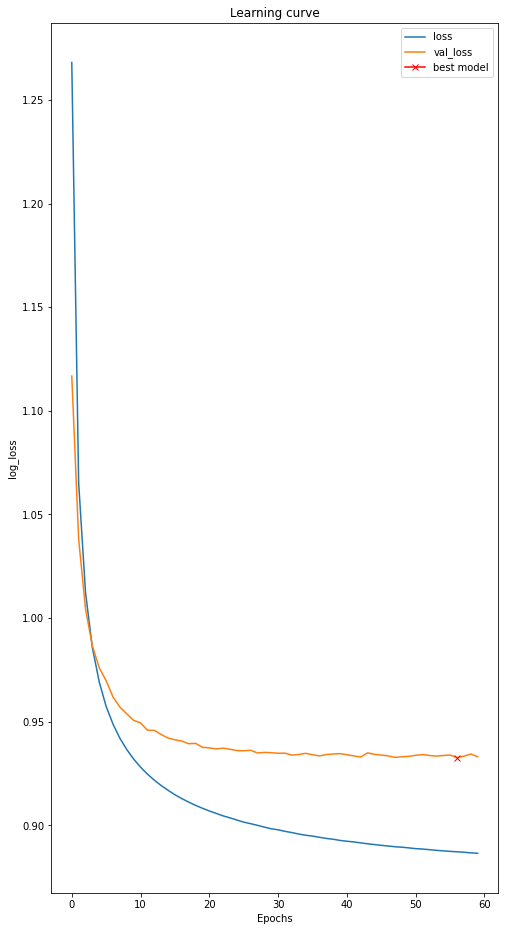

In [64]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

model=models.Sequential()
model.add(LSTM(168, input_shape=(Tx, len(characters)),dropout=0, return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

# train
model.compile(loss='categorical_crossentropy', optimizer="adam")
history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=60, shuffle=True, callbacks=[print_callback],verbose=1)

# show
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(8, 16))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 25, 168)           141792    
_________________________________________________________________
dense_11 (Dense)             (None, 25, 42)            7098      
Total params: 148,890
Trainable params: 148,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
6314/6317 [============================>.] - ETA: 0s - loss: 1.3850
apricos lansenne oy
rw geal oy
jrinms oy
6317/6317 [==============================] - 92s 14ms/step - loss: 1.3850 - val_loss: 1.1701
Epoch 2/60
6314/6317 [============================>.] - ETA: 0s - loss: 1.2187
pkt aakkiari oy
mbl tact oy
j ä särkötet oy
6317/6317 [==============================] - 91s 14ms/step - loss: 1.2187 - val_loss: 1.0883
Epoch 3/60
6313/6317 [============================>.] - ETA: 0s - loss: 1.1737
c

Epoch 36/60
6316/6317 [============================>.] - ETA: 0s - loss: 1.0770
kunshit oy
starmami oy
vn taloke la oy
6317/6317 [==============================] - 88s 14ms/step - loss: 1.0770 - val_loss: 0.9593
Epoch 37/60
6313/6317 [============================>.] - ETA: 0s - loss: 1.0765
argomountin oy
asunto oy tuilikarpa 47
spoe el oy
6317/6317 [==============================] - 88s 14ms/step - loss: 1.0765 - val_loss: 0.9603
Epoch 38/60
6316/6317 [============================>.] - ETA: 0s - loss: 1.0757
pominmaan turvetukku oy
sähkötyö huvila oy
ertor oy
6317/6317 [==============================] - 89s 14ms/step - loss: 1.0757 - val_loss: 0.9594
Epoch 39/60
6317/6317 [==============================] - ETA: 0s - loss: 1.0751
timeb oy
medaul oy
vs kif medical oy
6317/6317 [==============================] - 83s 13ms/step - loss: 1.0751 - val_loss: 0.9584
Epoch 40/60
6314/6317 [============================>.] - ETA: 0s - loss: 1.0748
jepäs petal oy
pitcareviam oy
asunto oy kotakari 9

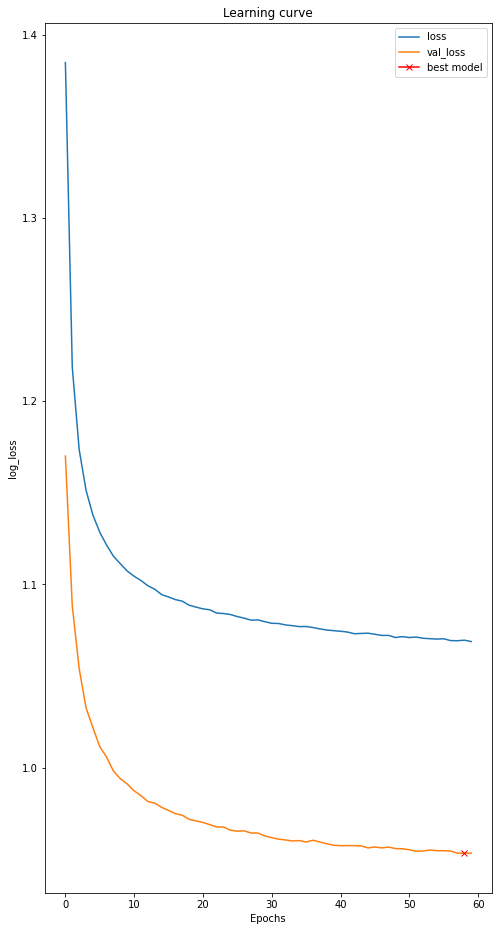

In [67]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

model=models.Sequential()
model.add(LSTM(168, input_shape=(Tx, len(characters)), dropout=0.2, return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

# train
model.compile(loss='categorical_crossentropy', optimizer="adam")
history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=60, shuffle=True, callbacks=[print_callback],verbose=1)

# show
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(8, 16))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 25, 256)           306176    
_________________________________________________________________
dense_12 (Dense)             (None, 25, 42)            10794     
Total params: 316,970
Trainable params: 316,970
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
6315/6317 [============================>.] - ETA: 0s - loss: 1.2222
timer oy
quaiton kolttot oy
ptrexor oy
6317/6317 [==============================] - 125s 20ms/step - loss: 1.2222 - val_loss: 1.0696
Epoch 2/60
6315/6317 [============================>.] - ETA: 0s - loss: 1.0208
rs oy
adasauema oy
xs oy
6317/6317 [==============================] - 121s 19ms/step - loss: 1.0208 - val_loss: 0.9962
Epoch 3/60
6316/6317 [============================>.] - ETA: 0s - loss: 0.9702
lesum martimed oy
40

Epoch 39/60
6315/6317 [============================>.] - ETA: 0s - loss: 0.8468
ratkis oy
pen oy
lomas oy
6317/6317 [==============================] - 162s 26ms/step - loss: 0.8468 - val_loss: 0.9287
Epoch 40/60
6315/6317 [============================>.] - ETA: 0s - loss: 0.8463
la oy ltd
kas oy
ll oy
6317/6317 [==============================] - 170s 27ms/step - loss: 0.8463 - val_loss: 0.9286
Epoch 41/60
6315/6317 [============================>.] - ETA: 0s - loss: 0.8458
 oy
iset multiaasto oy
chemills oy
6317/6317 [==============================] - 161s 25ms/step - loss: 0.8458 - val_loss: 0.9282
Epoch 42/60
6316/6317 [============================>.] - ETA: 0s - loss: 0.8454
lex oy
k oy
 morohelmi oy
6317/6317 [==============================] - 160s 25ms/step - loss: 0.8454 - val_loss: 0.9293
Epoch 43/60
6316/6317 [============================>.] - ETA: 0s - loss: 0.8451
bonus oy
ndo oy ab
natural ab ltd
6317/6317 [==============================] - 159s 25ms/step - loss: 0.8451 - val

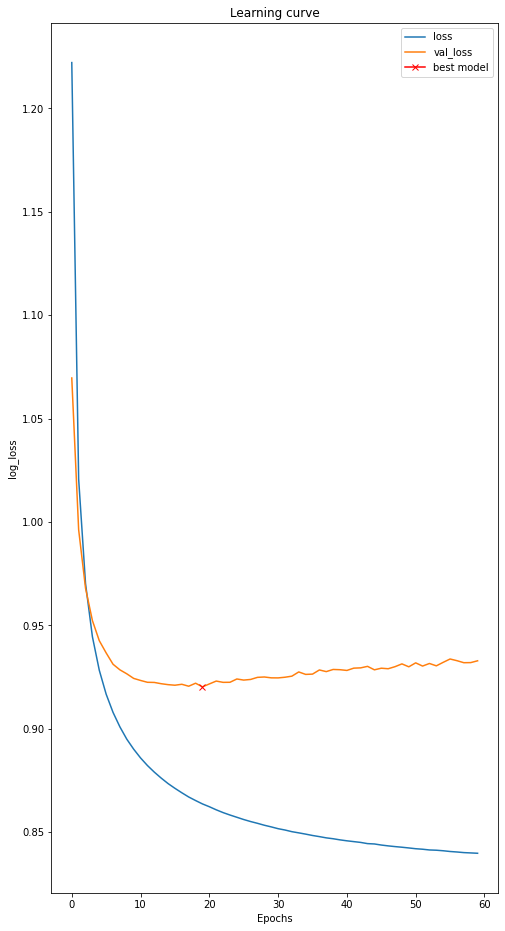

In [68]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

model=models.Sequential()
model.add(LSTM(256, input_shape=(Tx, len(characters)), dropout=0, return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

# train
model.compile(loss='categorical_crossentropy', optimizer="adam")
history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=60, shuffle=True, callbacks=[print_callback],verbose=1)

# show
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(8, 16))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 25, 256)           306176    
_________________________________________________________________
dense_13 (Dense)             (None, 25, 42)            10794     
Total params: 316,970
Trainable params: 316,970
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
6316/6317 [============================>.] - ETA: 0s - loss: 1.3542
ergall oy
oy kori taparima btd
visa group oy
6317/6317 [==============================] - 235s 37ms/step - loss: 1.3542 - val_loss: 1.1264
Epoch 2/60
6315/6317 [============================>.] - ETA: 0s - loss: 1.1809
moskuoni auniitolut oy
briinfrem oy
pe men oy
6317/6317 [==============================] - 231s 37ms/step - loss: 1.1809 - val_loss: 1.0461
Epoch 3/60
6316/6317 [============================>.] - ETA: 0s - loss: 

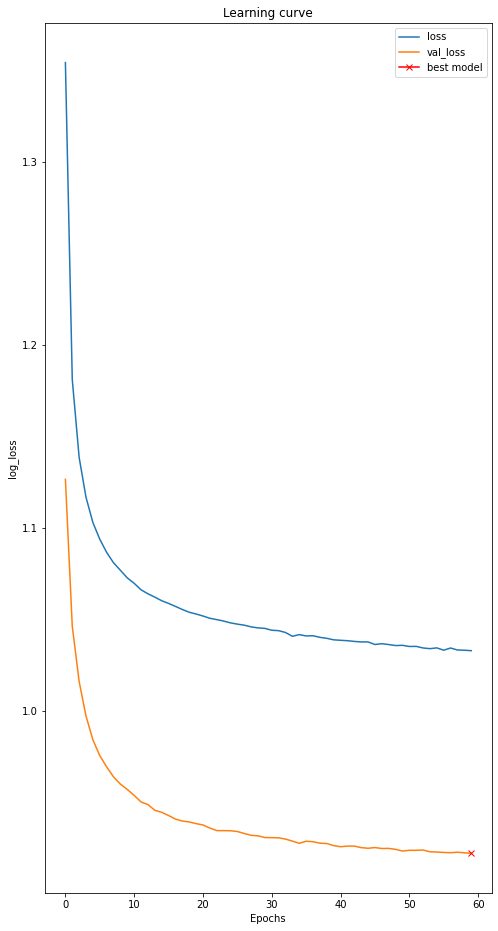

In [69]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

model=models.Sequential()
model.add(LSTM(256, input_shape=(Tx, len(characters)), dropout=0.2, return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

# train
model.compile(loss='categorical_crossentropy', optimizer="adam")
history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=60, shuffle=True, callbacks=[print_callback],verbose=1)

# show
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(8, 16))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


In [ ]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

model=models.Sequential()
model.add(LSTM(256, input_shape=(Tx, len(characters)), dropout=0.1, return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

# train
model.compile(loss='categorical_crossentropy', optimizer="adam")
history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=60, shuffle=True, callbacks=[print_callback],verbose=1)

# show
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(8, 16))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


In [ ]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

model=models.Sequential()
model.add(LSTM(512, input_shape=(Tx, len(characters)), dropout=0, return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

# train
model.compile(loss='categorical_crossentropy', optimizer="adam")
history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=60, shuffle=True, callbacks=[print_callback],verbose=1)

# show
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(8, 16))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 25, 512)           1136640   
_________________________________________________________________
dense_14 (Dense)             (None, 25, 42)            21546     
Total params: 1,158,186
Trainable params: 1,158,186
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
6317/6317 [==============================] - ETA: 0s - loss: 1.3072
ahranvel oy
1131 eeg smane oy
c s lapitul oy
6317/6317 [==============================] - 787s 125ms/step - loss: 1.3072 - val_loss: 1.0696
Epoch 2/60
6316/6317 [============================>.] - ETA: 0s - loss: 1.1329
uvokeskus revlms oy
nakkolo oy
actiketyhoy
6317/6317 [==============================] - 559s 88ms/step - loss: 1.1329 - val_loss: 0.9983
Epoch 3/60
6316/6317 [============================>.] - ETA: 0s - loss

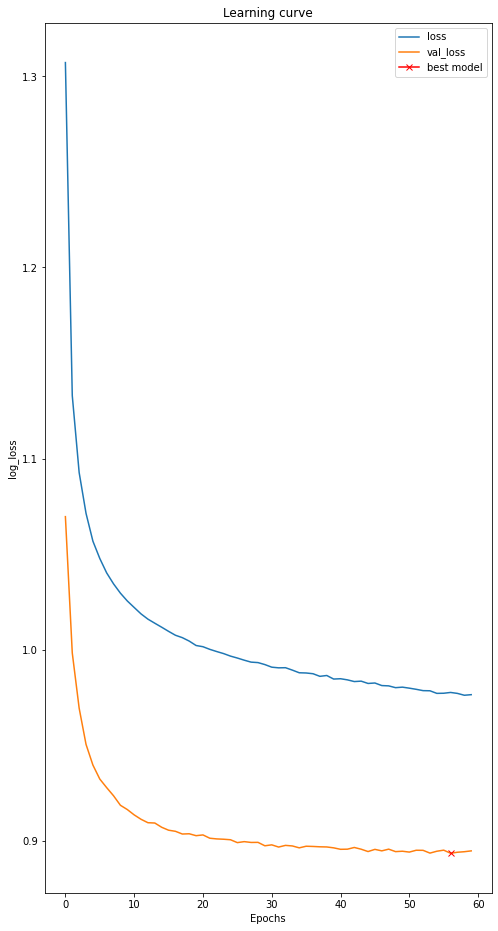

In [70]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

model=models.Sequential()
model.add(LSTM(512, input_shape=(Tx, len(characters)), dropout=0.2, return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

# train
model.compile(loss='categorical_crossentropy', optimizer="adam")
history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=60, shuffle=True, callbacks=[print_callback],verbose=1)

# show
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(8, 16))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


In [73]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

model=models.Sequential()
model.add(LSTM(1024, input_shape=(Tx, len(characters)), dropout=0.2, return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

# train
model.compile(loss='categorical_crossentropy', optimizer="adam")
history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=90, shuffle=True, callbacks=[print_callback],verbose=1)

# show
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(16, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 25, 1024)          4370432   
_________________________________________________________________
dense_17 (Dense)             (None, 25, 42)            43050     
Total params: 4,413,482
Trainable params: 4,413,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90
6317/6317 [==============================] - ETA: 0s - loss: 1.2699
karkita oy
dren lediq oy
jv caseto care oy
6317/6317 [==============================] - 2054s 325ms/step - loss: 1.2699 - val_loss: 1.0326
Epoch 2/90
6317/6317 [==============================] - ETA: 0s - loss: 1.1034
provire oy
virstinen oy sonrekki
parkaniversio oy
6317/6317 [==============================] - 2007s 318ms/step - loss: 1.1034 - val_loss: 0.9714
Epoch 3/90
6317/6317 [==============================] - ETA: 0

6317/6317 [==============================] - ETA: 0s - loss: 0.9317
tähtitekijät oy
kyrux oy
kuljetusliike priipako o
6317/6317 [==============================] - 1989s 315ms/step - loss: 0.9317 - val_loss: 0.8952
Epoch 36/90
6317/6317 [==============================] - ETA: 0s - loss: 0.9304
fissaknit oy
leiponen designs oy
v clue company oy
6317/6317 [==============================] - 1992s 315ms/step - loss: 0.9304 - val_loss: 0.8953
Epoch 37/90
6317/6317 [==============================] - ETA: 0s - loss: 0.9283
tual artggroup oy
sknetra sun oy
hevagsilvoo oy
6317/6317 [==============================] - 2019s 320ms/step - loss: 0.9283 - val_loss: 0.8948
Epoch 38/90
6317/6317 [==============================] - ETA: 0s - loss: 0.9277
deredo oy
pmk metalliset oy
vamako oy ltd
6317/6317 [==============================] - 2014s 319ms/step - loss: 0.9277 - val_loss: 0.8963
Epoch 39/90
1382/6317 [=====>........................] - ETA: 26:02 - loss: 0.9224

KeyboardInterrupt: 

In [118]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

model=models.Sequential()
model.add(GRU(512, input_shape=(Tx, len(characters)), dropout=0, return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

# train
model.compile(loss='categorical_crossentropy', optimizer="adam")
history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=60, shuffle=True, callbacks=[print_callback],verbose=1)

# show
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(16, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 15, 512)           854016    
_________________________________________________________________
dense_20 (Dense)             (None, 15, 42)            21546     
Total params: 875,562
Trainable params: 875,562
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
5161/5161 [==============================] - ETA: 0s - loss: 1.5609
imec oy
ccetrant oy
cc oy
5161/5161 [==============================] - 343s 66ms/step - loss: 1.5609 - val_loss: 1.4482
Epoch 2/60
5160/5161 [============================>.] - ETA: 0s - loss: 1.3985
s kaupen oy
järvi oy
rehosialainen
5161/5161 [==============================] - 332s 64ms/step - loss: 1.3985 - val_loss: 1.3789
Epoch 3/60
5160/5161 [============================>.] - ETA: 0s - loss: 1.3403
tympeiltä
icad oy
näris

KeyboardInterrupt: 

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 15, 512)           1136640   
_________________________________________________________________
dense_21 (Dense)             (None, 15, 42)            21546     
Total params: 1,158,186
Trainable params: 1,158,186
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
5161/5161 [==============================] - ETA: 0s - loss: 1.6620
y iviseca oy
losen oy
huseco oy
5161/5161 [==============================] - 347s 67ms/step - loss: 1.6620 - val_loss: 1.4943
Epoch 2/60
5161/5161 [==============================] - ETA: 0s - loss: 1.5044
akattrina oy
planstu oy
rovuna oy
5161/5161 [==============================] - 354s 69ms/step - loss: 1.5044 - val_loss: 1.4131
Epoch 3/60
5161/5161 [==============================] - ETA: 0s - loss: 1.4487
jancele oy
sty

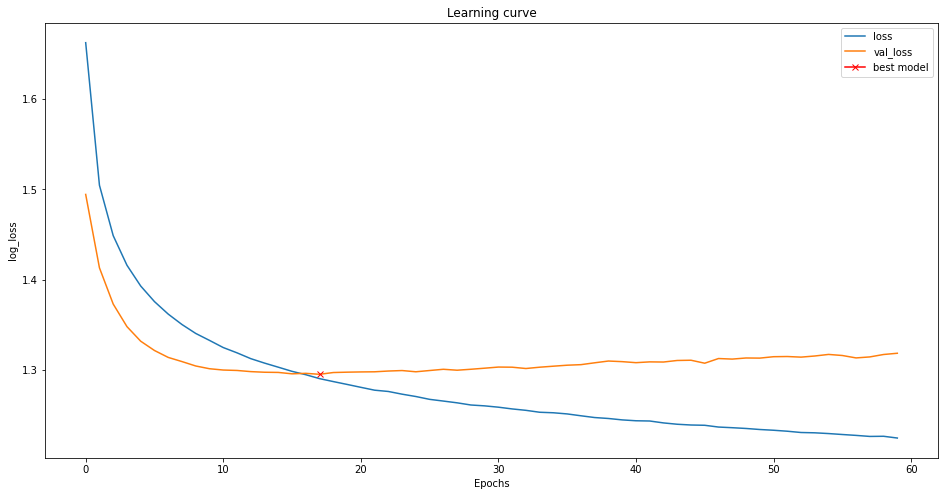

In [119]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

model=models.Sequential()
model.add(LSTM(512, input_shape=(Tx, len(characters)), dropout=0.1, return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

# train
model.compile(loss='categorical_crossentropy', optimizer="adam")
history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=60, shuffle=True, callbacks=[print_callback],verbose=1)

# show
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(16, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 15, 512)           1136640   
_________________________________________________________________
dense_22 (Dense)             (None, 15, 42)            21546     
Total params: 1,158,186
Trainable params: 1,158,186
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
5161/5161 [==============================] - ETA: 0s - loss: 1.7172
ykkämaka2oy
sihapr sy
orattaa
5161/5161 [==============================] - 352s 68ms/step - loss: 1.7172 - val_loss: 1.5177
Epoch 2/60
5160/5161 [============================>.] - ETA: 0s - loss: 1.5805
lautiohaeroja
käity aytelmin
käyriropi
5161/5161 [==============================] - 333s 65ms/step - loss: 1.5805 - val_loss: 1.4426
Epoch 3/60
5161/5161 [==============================] - ETA: 0s - loss: 1.5361
fintala ab


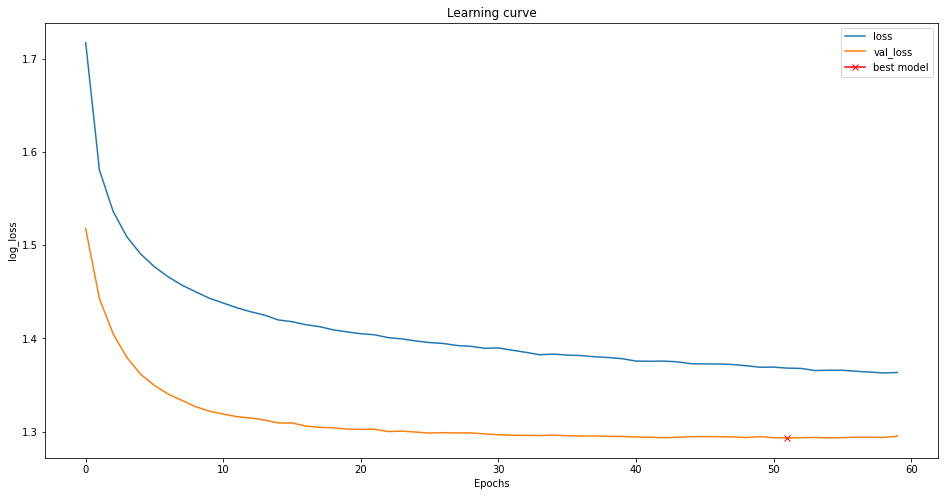

In [120]:
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU

model=models.Sequential()
model.add(LSTM(512, input_shape=(Tx, len(characters)), dropout=0.2, return_sequences=True))
model.add(Dense(len(characters),activation="softmax"))
model.summary()

# train
model.compile(loss='categorical_crossentropy', optimizer="adam")
history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=60, shuffle=True, callbacks=[print_callback],verbose=1)

# show
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(16, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


In [121]:
model.save("comp_dict_512_02.h5")

Epoch 1/54
8518/8518 [==============================] - ETA: 0s - loss: 1.5314
tektodona oy
bqsre tech
pic tel turuno
8518/8518 [==============================] - 523s 61ms/step - loss: 1.5314 - val_loss: 1.4078
Epoch 2/54
8518/8518 [==============================] - ETA: 0s - loss: 1.5282
semik
madrajek tilit
digicomate
8518/8518 [==============================] - 581s 68ms/step - loss: 1.5282 - val_loss: 1.4060
Epoch 3/54
8518/8518 [==============================] - ETA: 0s - loss: 1.5243
intyra
au artila oy
anpurby io
8518/8518 [==============================] - 623s 73ms/step - loss: 1.5243 - val_loss: 1.4043
Epoch 4/54
8518/8518 [==============================] - ETA: 0s - loss: 1.5220
fajatech
mlttarit ab
epnan imports
8518/8518 [==============================] - 722s 85ms/step - loss: 1.5220 - val_loss: 1.4026
Epoch 5/54
8518/8518 [==============================] - ETA: 0s - loss: 1.5195
admcha2a
brilent labs
redip usina oy
8518/8518 [==============================] - 689s 81ms/

Epoch 41/54
8517/8518 [============================>.] - ETA: 0s - loss: 1.4841
raft oy
unicron bikaty
marinkurma oy
8518/8518 [==============================] - 500s 59ms/step - loss: 1.4841 - val_loss: 1.3939
Epoch 42/54
8517/8518 [============================>.] - ETA: 0s - loss: 1.4840
alce cia
camiq oy
itaya oy
8518/8518 [==============================] - 500s 59ms/step - loss: 1.4840 - val_loss: 1.3941
Epoch 43/54
8517/8518 [============================>.] - ETA: 0s - loss: 1.4830
senvense oy
encels
spay
8518/8518 [==============================] - 500s 59ms/step - loss: 1.4830 - val_loss: 1.3933
Epoch 44/54
8517/8518 [============================>.] - ETA: 0s - loss: 1.4835
cff mrbia oy
vatorses oy
lokspir uk ltd
8518/8518 [==============================] - 497s 58ms/step - loss: 1.4835 - val_loss: 1.3935
Epoch 45/54
8517/8518 [============================>.] - ETA: 0s - loss: 1.4819
briefer
ulqestrach ag
consecdor oy
8518/8518 [==============================] - 490s 58ms/step -

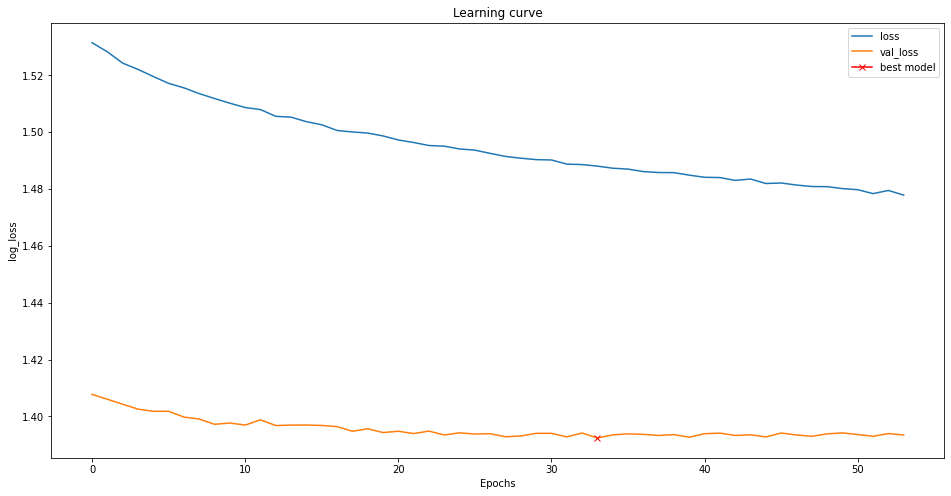

In [183]:
# training to be closer to tech companies
from keras import layers, models
from keras.layers import Dense, Input, LSTM,GRU


model=keras.models.load_model("comp_dict_512_02.h5")
model.compile(loss='categorical_crossentropy', optimizer="adam")
history=model.fit(X, Y, batch_size=32, validation_split=0.1,  epochs=54, shuffle=True, callbacks=[print_callback],verbose=1)

# show
import matplotlib
from matplotlib import pyplot as plt

results=history

plt.figure(figsize=(16, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


In [184]:
from keras.preprocessing import sequence
import math

empty="."
eos="E"
eos_index=char_indices[eos]
xn=len(characters)


def predict_tree(x, position, k):
    prediction=model.predict(x.astype(bool).astype(float))[0]
    pred=prediction[position]
    
    indices = pred.argsort()[-k:]
    #print(f"{vec_to_str(x[0])} -> {vec_to_str(prediction)} -> {indices}")
    results=np.zeros((0, Tx, xn))
    for index in indices:
        res=np.array(x, copy=True)
        res[0,position+1,index]=pred[index]
        if index==eos_index:
            results=np.append(results,res,axis=0)
            break
        if position==Tx-2:
            results=np.append(results,res,axis=0)
            break
        results=np.append(results,predict_tree(res,position+1,k), axis=0)
    return results


def beamsearch(k, cnt):
    x = np.zeros((1, Tx, xn)) # starting with 0
    res=predict_tree(x, 0, k)
    probs=[]
    for sample in res:
        sample_prob=1
        for char in sample:
            ch_prob=char.max()            
            if ch_prob>0:
                sample_prob+=math.log(ch_prob)
        probs.append(sample_prob)
    samples=[vec_to_str(a) for a in np.take(res,np.argsort(probs)[-cnt:],axis=0)]
    probs=np.take(probs,np.argsort(probs))[-cnt:]
    return list(zip(probs,samples))
    
    
res=beamsearch(k=2,cnt=50)
for prob, sample in res:
    print(f"{prob:0.5f}: {sample}")

-13.71206: salonit oy
-13.71034: server it
-13.70430: alter it
-13.69660: sense inc
-13.52143: seritech
-13.45746: sentino oy
-13.43899: servisor oy
-13.43236: sales oy
-13.41360: artisto oy
-13.39146: sales it
-13.29383: ariston oy
-13.27998: sense it
-13.26745: serin oy
-13.25718: sandin oy
-13.22963: allan oy
-13.19839: sentine oy
-13.17014: sentra oy
-13.15469: santer oy
-13.13851: santara oy
-13.10008: allin oy
-13.01396: allas oy
-12.94678: arista oy
-12.93645: altan oy
-12.89455: sensen oy
-12.89036: santech
-12.86375: saloni oy
-12.85927: alliance
-12.83739: sentrix
-12.77750: seritec oy
-12.77302: senson oy
-12.76937: allia oy
-12.75723: artico oy
-12.67029: sensor oy
-12.66855: artica oy
-12.66505: aristo oy
-12.60108: santa oy
-12.53804: sandi oy
-12.50825: altera oy
-12.46881: service it
-12.43060: altech
-12.41656: altec oy
-12.25457: artech
-12.13734: aris oy
-12.12818: santec oy
-12.07289: artec oy
-12.05856: artel oy
-11.98120: sanda oy
-11.94387: sense oy
-11.76570: ar

In [186]:
model.save("finn_techcomp_512_02.h5")

In [185]:
res=beamsearch(k=3,cnt=50)
for prob, sample in res:
    print(f"{prob:0.5f}: {sample}")

-12.54236: simpact
-12.53804: sandi oy
-12.53371: aritec
-12.53224: secure it
-12.53173: alta oy
-12.52534: seria oy
-12.51037: time it
-12.50825: altera oy
-12.46583: tilla oy
-12.45909: tartek oy
-12.44829: teline oy
-12.44679: tilitek oy
-12.43060: altech
-12.42686: tila oy
-12.41656: altec oy
-12.40758: arita oy
-12.40662: altis
-12.40635: teras oy
-12.36162: technologic
-12.35441: simple it
-12.34981: talla oy
-12.32693: appsoft
-12.31300: tilitiimi oy
-12.31056: tecnologica
-12.30744: sinet oy
-12.29252: tervan oy
-12.27936: tie oy
-12.27670: arter oy
-12.26167: technosoft
-12.25457: artech
-12.23727: technet
-12.21152: simply
-12.16841: tecnolink
-12.15419: techsoft
-12.13734: aris oy
-12.07289: artec oy
-12.06569: tella oy
-12.05856: artel oy
-12.00402: talli oy
-11.98120: sanda oy
-11.94387: sense oy
-11.93612: tecnet
-11.82836: tech it
-11.76570: artis oy
-11.67056: security
-11.64623: simplex
-11.58219: tecnologic
-11.53148: talotek oy
-11.38926: technology
-11.24568: servic

In [ ]:
0.00069: tori oy
0.00071: star oy
0.00079: san oy
0.00080: sa oy
0.00083: sol oy
0.00091: steel oy
0.00133: tek oy
0.00136: tor oy
0.00181: ti oy
0.00189: to oy

In [131]:
0.00047: teri oy
0.00063: onet oy
0.00065: omi oy
0.00069: tori oy
0.00074: ton oy
0.00084: tone oy
0.00133: tek oy
0.00136: tor oy
0.00150: oma oy
0.00259: one oy


1

In [173]:
for prob, sample in res:
    print(f"{prob:0.5f}: {sample}")

0.00069: tori oy
0.00071: star oy
0.00079: san oy
0.00080: sa oy
0.00083: sol oy
0.00091: steel oy
0.00133: tek oy
0.00136: tor oy
0.00181: ti oy
0.00189: to oy


In [ ]:
# + beam search
# + end of line character should be zeros

# + try a very small lstm model
# [] find lstm model size
# try GRU

# train language model for the beam search
# dropout
# save best model

